# Multi-Factor Equity Portfolio Optimizer

This notebook will demonstrate a basic implementation I've experimented with of a factor-based equity portfolio optimiser, using Python. We use momentum and volatility as example factors, rank stocks based on them, and then test this strategy by seeing how monthly investments in these stocks would perform

## 1. Importing Relevant Libraries

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

The Yahoo Finance module yfinance will give us the up-to-date stock price data we need. Pandas provides us with a way of loading data frames. Matplotlib, of course, will help us analyse our results visually when we produce a graph.

## 2. Gathering Stock Ticker Info

In [9]:
url = "https://en.wikipedia.org/wiki/FTSE_100_Index"
tables = pd.read_html(url)
ftse_table = tables[6]  #Location of ticker information on the site can change so must be kept updated
tickers = ftse_table['Ticker'].tolist()
tickers = [ticker + ".L" for ticker in tickers]

print(tickers)

['III.L', 'ADM.L', 'AAF.L', 'ALW.L', 'AAL.L', 'ANTO.L', 'AHT.L', 'ABF.L', 'AZN.L', 'AUTO.L', 'AV.L', 'BAB.L', 'BA.L', 'BARC.L', 'BTRW.L', 'BEZ.L', 'BKG.L', 'BP.L', 'BATS.L', 'BT-A.L', 'BNZL.L', 'CNA.L', 'CCEP.L', 'CCH.L', 'CPG.L', 'CTEC.L', 'CRDA.L', 'DCC.L', 'DGE.L', 'DPLM.L', 'EDV.L', 'ENT.L', 'EZJ.L', 'EXPN.L', 'FCIT.L', 'FRES.L', 'GAW.L', 'GLEN.L', 'GSK.L', 'HLN.L', 'HLMA.L', 'HIK.L', 'HSX.L', 'HWDN.L', 'HSBA.L', 'ICG.L', 'IHG.L', 'IMI.L', 'IMB.L', 'INF.L', 'IAG.L', 'ITRK.L', 'JD.L', 'KGF.L', 'LAND.L', 'LGEN.L', 'LLOY.L', 'LMP.L', 'LSEG.L', 'MNG.L', 'MKS.L', 'MRO.L', 'MNDI.L', 'NG.L', 'NWG.L', 'NXT.L', 'PSON.L', 'PSH.L', 'PSN.L', 'PHNX.L', 'PCT.L', 'PRU.L', 'RKT.L', 'REL.L', 'RTO.L', 'RMV.L', 'RIO.L', 'RR.L', 'SGE.L', 'SBRY.L', 'SDR.L', 'SMT.L', 'SGRO.L', 'SVT.L', 'SHEL.L', 'SMIN.L', 'SN.L', 'SPX.L', 'SSE.L', 'STAN.L', 'STJ.L', 'TW.L', 'TSCO.L', 'ULVR.L', 'UU.L', 'UTG.L', 'VOD.L', 'WEIR.L', 'WTB.L', 'WPP.L']


Wikipedia holds an up-to-date list of the stocks which make up the FTSE100 and their respective Tickers. We pull this information from the site and store it in a list of data frames. There is then a column in the 7th table of all 100 stock tickers, which we then store as a list. The ".L" must be added, as it's a key used by Yahoo Finance when dealing with stocks on the London Stock Exchange. There is a code fragility since stock ticker information on wikipedia could move at some point in the future. If this ever happens, it would be appreciated if an issue could be raised.

## 2. Factor Calculation: Momentum & Volatility

In [10]:
prices = yf.download(tickers, start='2023-01-01',auto_adjust=True)['Close']
prices = prices.dropna()

momentum = prices.pct_change(63)
volatility = prices.pct_change().rolling(63).std() 

latest_momentum = momentum.iloc[-1]
latest_volatility = volatility.iloc[-1]

factors = pd.DataFrame({
    'momentum': latest_momentum,
    'volatility': latest_volatility
})
factors.dropna(inplace=True)

print(factors.head())

[*********************100%***********************]  100 of 100 completed

        momentum  volatility
Ticker                      
AAF.L   0.182729    0.019930
AAL.L   0.085674    0.022808
ABF.L   0.021562    0.017814
ADM.L   0.042056    0.009122
AHT.L   0.271162    0.019366


We download the closing prices of our desired tickers from the Yahoo Finance module and remove non-trading days with no stock price data. We can determine momentum by taking a rolling 3-month percentage change of each stock price. Similarly, we'll determine volatility by taking the returns of the last 63 days and taking the standard deviation: a higher standard deviation suggests more uncertainty and volatility. This gives us two time series from which we can take the last value of each to determine the latest momentum and volatility of our stocks. We put these in a data frame for easier manipulation next.

## 3. Ranking Stocks and Determining Weights

In [11]:
# Normalize factors: higher momentum is better, lower volatility is better
factors['momentum_score'] = (factors['momentum'] - factors['momentum'].mean()) / factors['momentum'].std()
factors['volatility_score'] = - (factors['volatility'] - factors['volatility'].mean()) / factors['volatility'].std()

# Combine scores equally
factors['composite_score'] = (factors['momentum_score'] + factors['volatility_score']) / 2

# Normalize to get portfolio weights
weights = factors['composite_score']
weights = weights.clip(lower=0)
weights = weights / weights.sum()

print(weights.head())
print(sum(weights))

Ticker
AAF.L    0.000000
AAL.L    0.000000
ABF.L    0.000000
ADM.L    0.016968
AHT.L    0.000187
Name: composite_score, dtype: float64
1.0


We create new columns which score each stocks momentum and volatility using normalisation. We take the negative of the volatility scores since a lower volatility is better. We combine the scores by taking the mean of both. This could be experimented with later by weighting volatility or momentum more if we had reason to believe one was more important. We take all positively scoring stocks and normalise once more to get a proportion of how much we should invest in each.

### Aside: Static vs Dynamic Weighting
In this example we use static weighting: we determine our weights from the first 3 months of data and do not change them in response to the new data which continues to come through. The reason for this is because it is easier to implement and understand. Should I continue this project I would next test dynamic weighting, where the weights change continuously in light of new stock price information.

## 4. Test Portfolio vs Benchmark

In [12]:
monthly_prices = prices.resample('ME').last()
returns = monthly_prices.pct_change().dropna()
portfolio_returns = (returns * weights).sum(axis=1)

benchmark = yf.download('^FTSE', start='2023-01-01',auto_adjust=True)['Close']
benchmark = benchmark.resample('ME').last()
benchmark_returns = benchmark.pct_change().dropna()

cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_benchmark = (1 + benchmark_returns).cumprod()



[*********************100%***********************]  1 of 1 completed


We take the last price of each month and find each stocks returns by calculating the percentage change of each consequent month. Our portfolio returns are then the sum of the stock returns multiplied by the weights of each stock we are investing in. We will download FTSE stock prices to compare our portfolio returns against investing all our money in the index. finally. The cumulative produce will simulate the compound effect of daily returns over time.

## 5. Plot of the results

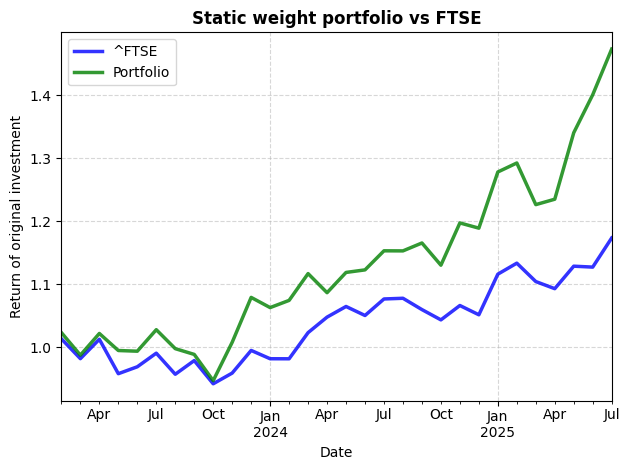

In [13]:
cumulative_benchmark.plot(label='Benchmark', linewidth=2.5, alpha=0.8, color='blue')
cumulative_portfolio.plot(label='Portfolio', linewidth=2.5, alpha=0.8, color='green')
plt.legend()
plt.ylabel("Return of original investment")
plt.xlabel("Date")
plt.title('Static weight portfolio vs FTSE', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5) 
plt.tight_layout()
plt.savefig("plot.png")

The plot of our results is very positive, it shows a return 30% greater than the FTSE100.